In [65]:
import numpy as np
import pandas as pd
import pickle
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression
from sklearn.metrics import mean_squared_error

In [66]:
cs2_odds_df = pd.read_pickle("dataframes/polished_mainframe.pkl")
cs2_odds_df = cs2_odds_df.astype(float)

# remove outliers
cs2_odds_df = cs2_odds_df[np.abs(stats.zscore(cs2_odds_df['total_kills'])) < 3]

# split off results before normalization
cs2_odds_df_results = cs2_odds_df['total_kills']

# Split results between training, dev, and test
cs2_odds_df_training_results = cs2_odds_df_results.head((len(cs2_odds_df.index) * 7) // 10)
cs2_odds_df_dev_results = cs2_odds_df_results.iloc[((len(cs2_odds_df.index) * 7) // 10):((len(cs2_odds_df.index) * 9) // 10) - 1]
cs2_odds_df_test_results = cs2_odds_df_results.tail((len(cs2_odds_df.index) * 1) // 10)

cs2_odds_df.drop(columns=['total_kills'], axis=1, inplace=True)

In [67]:
# Normalize data before spltting off
cs2_odds_df=(cs2_odds_df-cs2_odds_df.min())/(cs2_odds_df.max()-cs2_odds_df.min())
# Split data between training, dev, and test
cs2_odds_df_training = cs2_odds_df.head((len(cs2_odds_df.index) * 7) // 10)
cs2_odds_df_dev = cs2_odds_df.iloc[((len(cs2_odds_df.index) * 7) // 10):((len(cs2_odds_df.index) * 9) // 10) - 1]
cs2_odds_df_test = cs2_odds_df.tail((len(cs2_odds_df.index) * 1) // 10)

     team_rank  opponent_rank  kills_per_round  kills_per_round_win  \
215   0.365385       0.119231         0.581818             0.777778   
140   0.165385       0.511538         0.490909             0.513889   
182   0.226923       0.192308         0.672727             0.736111   
66    0.092308       0.107692         0.345455             0.347222   
43    0.434615       0.569231         0.509091             0.652778   

     rounds_with_a_kill  rounds_with_a_multikill  damage_per_round  \
215            0.595918                 0.591549          0.662338   
140            0.546939                 0.488263          0.471861   
182            0.751020                 0.615023          0.725108   
66             0.383673                 0.380282          0.406926   
43             0.583673                 0.478873          0.593074   

     damage_per_round_win    rating  saved_by_teammate_per_round  ...  \
215              0.772071  0.506667                     0.733333  ...   
140   

In [68]:
# Split off results
cs2_odds_df_training_results = cs2_odds_df_training_results.values.ravel()
cs2_odds_df_dev_results = cs2_odds_df_dev_results.values.ravel()
cs2_odds_df_test_results = cs2_odds_df_test_results.values.ravel()

In [6]:
from sklearn.model_selection import RandomizedSearchCV

# https://medium.com/data-science/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 100)]
# Number of features to consider at every split
max_features = ['auto', 0.6, 0.8, 1.0]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4, 8, 16, 32]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 500, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(cs2_odds_df_training, cs2_odds_df_training_results)

Fitting 3 folds for each of 500 candidates, totalling 1500 fits


C:\Users\damie\cs2_predictor\scrape_and_ml\lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
759 fits failed out of a total of 1500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
580 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\damie\cs2_predictor\scrape_and_ml\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\damie\cs2_predictor\scrape_and_ml\lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "C:\Users\damie\cs2_predictor\scrape_and_ml\lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validat

RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=500,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 1.0],
                                        'min_samples_leaf': [1, 2, 4, 8, 16,
                                                             32],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 218, 236, 254,
                                                         272, 290, 309, 327,
                                                         345, 363, 381, 400,
                                                         418, 436, 454, 472,
                                                         490, 509, 527, 545,
                                                         563, 581, 600, 618,
                                                         636, 654, 672, 690,
                                                         709, 727, ...]},
                   random_state=42, verbose=2)

In [69]:
# dev set experimentation
reg = RandomForestRegressor(n_estimators=400, min_samples_leaf=8, max_depth=10, min_samples_split=10).fit(cs2_odds_df_training, cs2_odds_df_training_results)
score = reg.score(cs2_odds_df_dev, cs2_odds_df_dev_results)
print(f'Random Forest dev Score: {score}')
y_predicted = reg.predict(cs2_odds_df_dev)
rmse = np.sqrt(mean_squared_error(cs2_odds_df_dev_results, y_predicted))
print(f'Random Forest dev RMSE: {rmse}')

Random Forest dev Score: 0.08858889120943947
Random Forest dev RMSE: 7.789261673769626


In [48]:
from sklearn.model_selection import GridSearchCV

# https://www.geeksforgeeks.org/random-forest-hyperparameter-tuning-in-python/

# Number of trees in random forest
n_estimators = [300, 400]
# Number of features to consider at every split
max_features = [1.0]
# Maximum number of levels in tree
max_depth = [5,10,15]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [5,10,15,20, 25, 30]
# Minimum number of samples required at each leaf node
min_samples_leaf = [8,10,12,14,16]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf = RandomForestRegressor()

grid_search = GridSearchCV(estimator = rf,
                           param_grid=param_grid,
                           cv = 3, 
                           verbose=2,
                           n_jobs = -1)
grid_search.fit(cs2_odds_df_training, cs2_odds_df_training_results)
print(grid_search.best_estimator_)

Fitting 3 folds for each of 480 candidates, totalling 1440 fits
RandomForestRegressor(max_depth=10, min_samples_leaf=12, min_samples_split=30,
                      n_estimators=400)


In [70]:
# dev set experimentation
reg = RandomForestRegressor(max_depth=10, 
                            min_samples_leaf=12, 
                            min_samples_split=30,
                            n_estimators=400).fit(cs2_odds_df_training, cs2_odds_df_training_results)
score = reg.score(cs2_odds_df_dev, cs2_odds_df_dev_results)
print(f'Random forest tuned dev Score: {score}')
y_predicted = reg.predict(cs2_odds_df_dev)
rmse = np.sqrt(mean_squared_error(cs2_odds_df_dev_results, y_predicted))
print(f'Random forest tuned dev RMSE: {rmse}')

Random Forest dev Score: 0.09441148835774205
Random Forest dev RMSE: 7.764340756716517


In [71]:
less_than_3_diff_count = 0
total_count = 0
for i in range(len(y_predicted)):
    if abs(y_predicted[i] - cs2_odds_df_dev_results[i]) < 3:
        less_than_3_diff_count += 1
    total_count+=1
print(less_than_3_diff_count)
print(less_than_3_diff_count / total_count)

177
0.29797979797979796


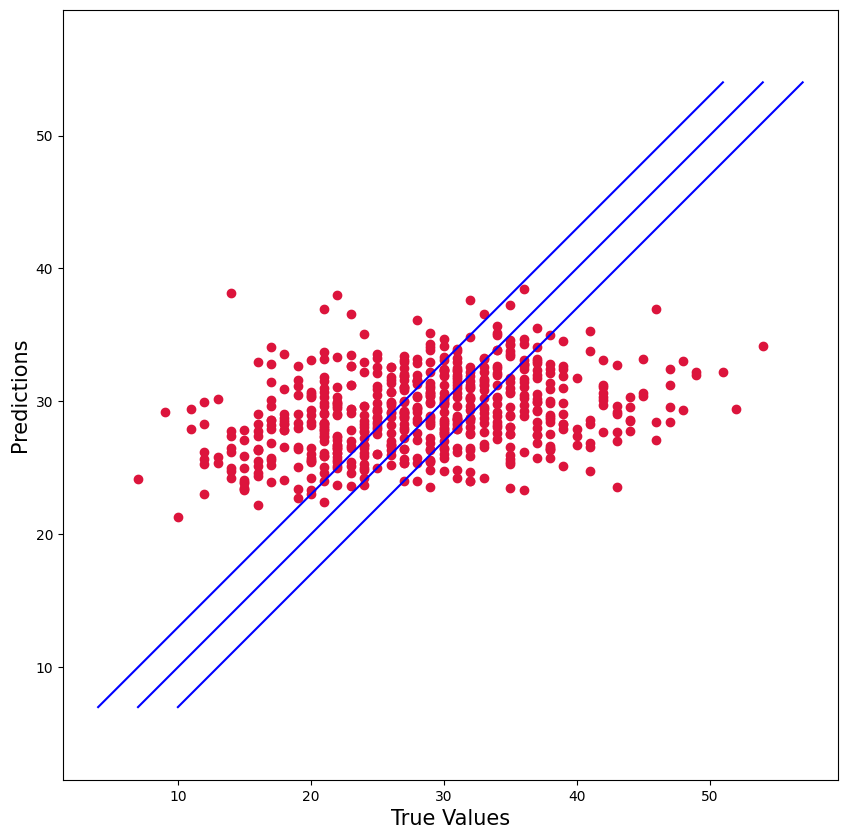

In [72]:
plt.figure(figsize=(10,10))
plt.scatter(cs2_odds_df_dev_results, y_predicted, c='crimson')
p1 = max(max(y_predicted), max(cs2_odds_df_test_results))
p2 = min(min(y_predicted), min(cs2_odds_df_test_results))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.plot([p1+3, p2+3], [p1, p2], 'b-')
plt.plot([p1-3, p2-3], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

In [44]:
for i in range(len(cs2_odds_df_dev.columns)):
    print(f'{cs2_odds_df_dev.columns[i]}: {reg.feature_importances_[i]}')
#         if reg.feature_importances_[i] < 0.01:
#             cs2_odds_df.drop(columns=cs2_odds_df.columns[i], axis=1, inplace=True)

team_rank: 0.026647764899022833
opponent_rank: 0.03486807190636013
kills_per_round: 0.024220806525847027
kills_per_round_win: 0.015159935743119355
rounds_with_a_kill: 0.10494313084630184
rounds_with_a_multikill: 0.033808631729126924
damage_per_round: 0.03964558746763927
damage_per_round_win: 0.02363190163187643
rating: 0.09305327152488976
saved_by_teammate_per_round: 0.008369115796749135
traded_deaths_per_round: 0.004108675227502166
traded_deaths_percentage: 0.021666076488480502
opening_deaths_traded_percentage: 0.025447708487580784
assists_per_round: 0.008002986902517868
support_rounds: 0.01947606357434052
saved_teammate_per_round: 0.006366209802765245
trade_kills_per_round: 0.006966704374844921
trade_kills_percentage: 0.023685903430261612
assisted_kills_percentage: 0.0362411576625738
damage_per_kill: 0.01095849224927056
opening_kills_per_round: 0.005563906088381433
opening_deaths_per_round: 0.004238410146355389
opening_attempts: 0.016135219817174543
opening_success: 0.022427116382322

In [45]:
# for i in range(len(cs2_odds_df)):
#     print(f'{cs2_odds_df.columns[i]}: {reg.feature_importances_[i]}')

In [73]:
#===========================================================================
# perform a scikit-learn Recursive Feature Elimination (RFE)
#===========================================================================
from sklearn.feature_selection import RFE
# here we want only one final feature, we do this to produce a ranking
n_features_to_select = 1
rfe = RFE(reg, n_features_to_select=n_features_to_select)
rfe.fit(cs2_odds_df_training, cs2_odds_df_training_results)

#===========================================================================
# now print out the features in order of ranking
#===========================================================================
from operator import itemgetter
features = cs2_odds_df_training.columns.to_list()
for x, y in (sorted(zip(rfe.ranking_ , features), key=itemgetter(0))):
    print(x, y)


#===========================================================================
# ok, this time let's choose the top 10 featues and use them for the model
#===========================================================================
n_features_to_select = 15
rfe = RFE(reg, n_features_to_select=n_features_to_select)
rfe.fit(cs2_odds_df_training, cs2_odds_df_training_results)

#===========================================================================
# use the model to predict the prices for the test data
#===========================================================================
# dev set experimentation
score = rfe.score(cs2_odds_df_dev, cs2_odds_df_dev_results)
print(f'Random forest with feature removal dev Score: {score}')
y_predicted = rfe.predict(cs2_odds_df_dev)
rmse = np.sqrt(mean_squared_error(cs2_odds_df_dev_results, y_predicted))
print(f'Random forest with feature removal dev RMSE: {rmse}')

1 rating
2 odds
3 rounds_with_a_kill
4 opponent_avg_rounds_won_in_losses
5 avg_rounds_lost_in_wins
6 avg_rounds_won_in_losses
7 opponent_avg_rounds_lost_in_wins
8 rounds_with_a_multikill
9 opening_success
10 trade_kills_percentage
11 damage_per_round_win
12 win_percentage_after_opening_kill
13 opening_deaths_traded_percentage
14 support_attacks_per_round
15 one_on_one_win_percentage
16 team_rank
17 kills_per_round
18 assisted_kills_percentage
19 traded_deaths_percentage
20 opening_attempts
21 opponent_rank
22 support_rounds
23 last_alive_percentage
24 damage_per_round
25 kills_per_round_win
26 damage_per_kill
27 opening_kills_per_round
28 assists_per_round
29 saved_by_teammate_per_round
30 saved_teammate_per_round
31 clutch_points_per_round
32 traded_deaths_per_round
33 trade_kills_per_round
34 opening_deaths_per_round
XGB dev Score: 0.10583821004215743
XGB dev RMSE: 7.715199999125007


In [74]:
# test set results
score = reg.score(cs2_odds_df_test, cs2_odds_df_test_results)
print(f'Random Forest test Score: {score}')
y_predicted = reg.predict(cs2_odds_df_test)
rmse = np.sqrt(mean_squared_error(cs2_odds_df_test_results, y_predicted))
print(f'Random Forest test RMSE: {rmse}')

Random Forest test Score: 0.1398354950844658
Random Forest test RMSE: 7.717976411667972


In [75]:
score = rfe.score(cs2_odds_df_test, cs2_odds_df_test_results)
print(f'Random forest with feature removal test score: {score}')
y_predicted = rfe.predict(cs2_odds_df_test)
rmse = np.sqrt(mean_squared_error(cs2_odds_df_test_results, y_predicted))
print(f'Random forest with feature removal test RMSE: {rmse}')

Random Forest test Score: 0.14888023299349207
Random Forest test RMSE: 7.677291430968886


In [76]:
less_than_3_diff_count = 0
total_count = 0
for i in range(len(y_predicted)):
    if abs(y_predicted[i] - cs2_odds_df_test_results[i]) < 3:
        less_than_3_diff_count += 1
    total_count+=1
print(less_than_3_diff_count)
print(less_than_3_diff_count / total_count)

92
0.30976430976430974


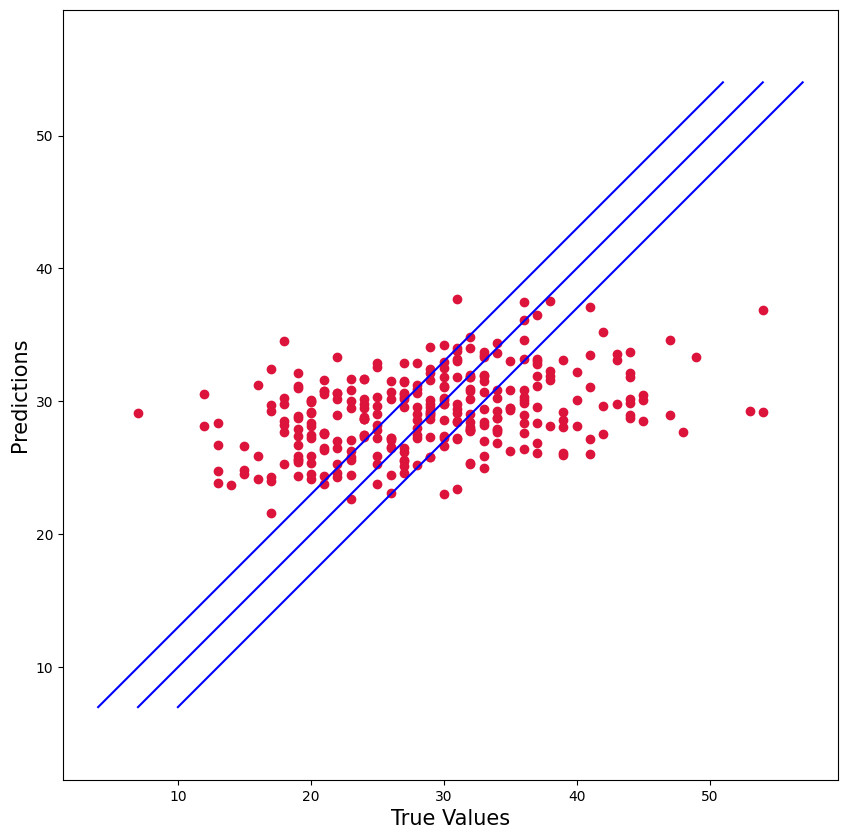

In [77]:
plt.figure(figsize=(10,10))
plt.scatter(cs2_odds_df_test_results, y_predicted, c='crimson')
p1 = max(max(y_predicted), max(cs2_odds_df_test_results))
p2 = min(min(y_predicted), min(cs2_odds_df_test_results))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.plot([p1+3, p2+3], [p1, p2], 'b-')
plt.plot([p1-3, p2-3], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()